# Downloading and exploring MNIST

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Label: 5


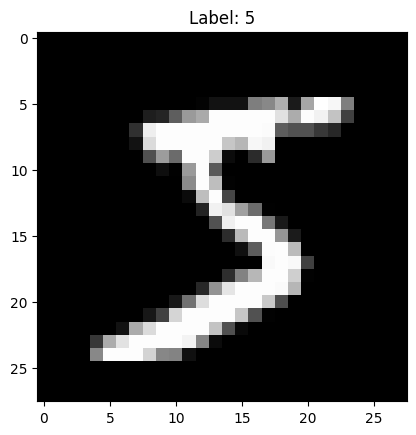

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform= transforms.ToTensor()  # without converting images to tensors, our model wont understand images mathematically

train_data= datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data= datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

image, label= train_data[0]
print(f"Image shape: {image.shape}")  # (1, 28, 28) - 1 channel, 28x28 pixels
print(f"Label: {label}")

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()



# Creating dataloaders

In [2]:
train_loader= DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Batches in train: {len(train_loader)}")
print(f"Batches in test: {len(test_loader)}")

images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")  # (64, 1, 28, 28) (batch, channel_dim, height,width )
print(f"Batch labels shape: {labels.shape}")

Batches in train: 938
Batches in test: 157
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


# Building the network

In [3]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten= nn.Flatten() # Flatten 28x28 image to 784 vector

        self.layer1= nn.Linear(784, 128)
        self.relu1= nn.ReLU()
        self.layer2= nn.Linear(128,64)
        self.relu2= nn.ReLU()
        self.layer3= nn.Linear(64,10)

    def forward(self, x):
        x= self.flatten(x)
        x= self.relu1(self.layer1(x))
        x= self.relu2(self.layer2(x))
        x= self.layer3(x)
        return x
    

model= DigitClassifier()
print(model)

DigitClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)


# Training Loop

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs= 5

for epoch in range(num_epochs):
    model.train()
    running_loss= 0 

    for batch_idx, (images,labels) in enumerate(train_loader):
        output= model(images)
        loss= criterion(output, labels) # fits into log loss as loss = -log(ptrue)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx+1)%100==0:
            print(f'epoch [{epoch+1}/{num_epochs}], batch {(batch_idx+1)}/{len(train_loader)}, loss: {loss.item()}')

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss}\n")


torch.save(model.state_dict(), "final_model.pth")



epoch [1/5], batch 100/938, loss: 0.07906286418437958
epoch [1/5], batch 200/938, loss: 0.033934976905584335
epoch [1/5], batch 300/938, loss: 0.03302209451794624
epoch [1/5], batch 400/938, loss: 0.0077977306209504604
epoch [1/5], batch 500/938, loss: 0.010788406245410442
epoch [1/5], batch 600/938, loss: 0.03614491969347
epoch [1/5], batch 700/938, loss: 0.03608058765530586
epoch [1/5], batch 800/938, loss: 0.04155070707201958
epoch [1/5], batch 900/938, loss: 0.01626824028789997
Epoch [1/5] completed. Average Loss: 0.0484

epoch [2/5], batch 100/938, loss: 0.0035507618449628353
epoch [2/5], batch 200/938, loss: 0.031892478466033936
epoch [2/5], batch 300/938, loss: 0.05673756077885628
epoch [2/5], batch 400/938, loss: 0.02308974787592888
epoch [2/5], batch 500/938, loss: 0.039714131504297256
epoch [2/5], batch 600/938, loss: 0.008756591007113457
epoch [2/5], batch 700/938, loss: 0.06009373441338539
epoch [2/5], batch 800/938, loss: 0.04485416039824486
epoch [2/5], batch 900/938, los

# Accuracy evaluation

In [15]:
model.eval()
correct=0
total=0

with torch.no_grad():
    for images,labels in test_loader:
        outputs= model(images)
        _, predicted= torch.max(outputs,1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


Test Accuracy: 97.61%


# Testing on individual images

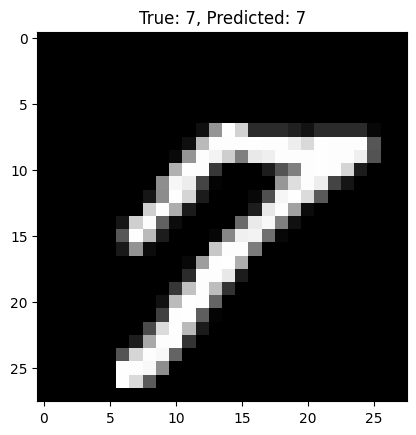

In [17]:
import random

idx= random.randint(0, len(test_data)-1)
image, true_label = test_data[idx]

with torch.no_grad():
    output= model(image.unsqueeze(0))
    _,predicted= torch.max(output, 1)

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted.item()}")
plt.show()



# Finding classification mistakes

18 amongst 100 images


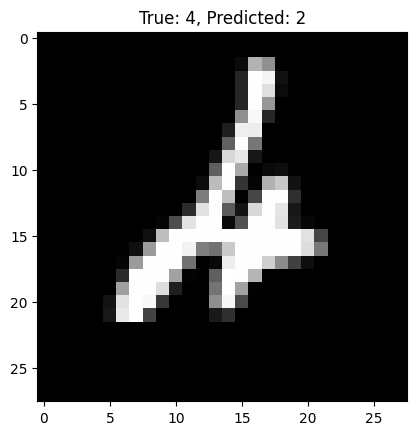

In [25]:
model.eval()
mistakes=[]

with torch.no_grad():
    for idx in range(1000):

        image, true_label= test_data[idx]
        output= model(image.unsqueeze(0))

        _, predicted= torch.max(output, 1)

        if predicted.item() != true_label :
            mistakes.append((idx,predicted,true_label))
    
    print(f'{len(mistakes)} amongst 100 images')

idx, predicted, true_label= mistakes[1]
image, _ = test_data[idx]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted.item()}")
plt.show()